This notebook computes the volume in which we can measure high-quality parallaxes (SNR>10) of ultracool dwarfs (brown dwarfs) for representative spectral types L7 on a variety of cadence simulations. An exploration of more spectral types in baseline only is in different notebook.

In [1]:

from lsst.sims.maf.metrics.baseMetric import BaseMetric
import lsst.sims.maf.utils as mafUtils
import lsst.sims.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

import glob


In [2]:
# Copy and modify the ParallaxMetric

class BDParallaxMetric(BaseMetric):
    """Calculate the distance to which one could reach a parallax SNR for a given object

    Uses columns ra_pi_amp and dec_pi_amp, calculated by the ParallaxFactorStacker.

    Parameters
    ----------
    metricName : str, opt
        Default 'parallax'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    seeingCol : str, opt
        The column name for the seeing information. Since the astrometry errors are based on the physical
        size of the PSF, this should be the FWHM of the physical psf. Default seeingFwhmGeom.
    mags : dict
        The absolute magnitude of the obeject in question. Keys of filter name, values in mags.
    distances : np.array
        Distances to try putting the object at (pc).
    atm_err : float, opt
        The expected centroiding error due to the atmosphere, in arcseconds. Default 0.01.
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='bdParallax', m5Col='fiveSigmaDepth',
                 filterCol='filter', seeingCol='seeingFwhmGeom',
                 badval=0, mags={'z': 18.18, 'y': 17.13}, parallax_snr=10.,
                 distances=np.arange(10, 500, 20),
                 atm_err=0.01, normalize=False, **kwargs):
        Cols = [m5Col, filterCol, seeingCol, 'ra_pi_amp', 'dec_pi_amp']
        
        units = 'pc'
        super(BDParallaxMetric, self).__init__(Cols, metricName=metricName, units=units,
                                             badval=badval, **kwargs)
        # set return type
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.distances = distances
        self.mags = {}
        distance_mod = 5.0*np.log10(distances)-5.0
        for key in mags:
            self.mags[key] = mags[key] + distance_mod
        self.parallax_snr_goal = parallax_snr
        self.atm_err = atm_err
        self.filters = list(self.mags.keys())
        self.parallaxes = 1000.0/distances  #mas
        
    def _final_sigma(self, position_errors, ra_pi_amp, dec_pi_amp):
        """Assume parallax in RA and DEC are fit independently, then combined.
        All inputs assumed to be arcsec """
        sigma_A = position_errors/ra_pi_amp
        sigma_B = position_errors/dec_pi_amp
        sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
        sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
        # Combine RA and Dec uncertainties, convert to mas
        sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3
        return sigma

    def run(self, dataslice, slicePoint=None):
        snr = np.zeros((np.size(self.mags[self.filters[0]]), len(dataslice)), dtype='float')
        # compute SNR for all observations
        for filt in self.filters:
            good = np.where(dataslice[self.filterCol] == filt)[0]
            if np.size(good) > 0:
                snr[:, good] = mafUtils.m52snr(self.mags[str(filt)][:, np.newaxis],
                                               dataslice[self.m5Col][good])
                
        
        position_errors = np.sqrt(mafUtils.astrom_precision(dataslice[self.seeingCol],
                                                            snr)**2+self.atm_err**2)
        # uncertainty in the parallax in mas
        sigma = self._final_sigma(position_errors, dataslice['ra_pi_amp'], dataslice['dec_pi_amp'])
        fitted_parallax_snr = self.parallaxes/sigma
        result = self.badval
        # Let's interpolate to the distance where we would get our target SNR
        if np.max(fitted_parallax_snr) >= self.parallax_snr_goal:
            f = interpolate.interp1d(fitted_parallax_snr, self.distances, fill_value="extrapolate")
            result = f(self.parallax_snr_goal)
        return result

In [3]:
class VolumeSumMetric(BaseMetric):
    """Compute the total volume assuming a metric has values of distance
    """
    def __init__(self, col=None, metricName='VolumeSum', nside=None, **kwargs):
        super(VolumeSumMetric, self).__init__(col=col, metricName=metricName, **kwargs)
        self.pix_area = hp.nside2pixarea(nside)
        
    def run(self, dataSlice, slicePoint=None):
        # volume of sphere, times ratio of pixel area divided by area of sphere
        vols = 1./3. * dataSlice[self.colname]**3 * self.pix_area
        return np.sum(vols)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter'].
Found 2224333 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_add_mag_cloudsv1_5_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 38.499  dipole: lon: 117.329, lat: -83.7157, amp: 10.512
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter'].
Found 2226702 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_big_sky_dustv1_5_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 38.5261  dipole: lon: 123.665, lat: -86.5135, amp: 14.0944
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter'].
Found 2233224 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_big_sky_nouiyv1_5_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 38.5973  dipole: lon: 126.327, lat: -85.9143, amp: 15.3487
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter'].
Found 2232598 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_big_skyv1_5_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 38.44  dipole: lon: 136.021, lat: -86.9238, amp: 15.3991
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter'].
Found 2230523 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_big_wfdv1_5_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 40.2407  dipole: lon: 111.165, lat: -76.1143, amp: 6.32683
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter'].
Found 2222665 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_bluer_footprintv1_5_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.1556  dipole: lon: 108.806, lat: -82.1074, amp: 10.2104
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter'].
Found 2223753 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_gp_smoothv1_5_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 39.4032  dipole: lon: -122.912, lat: -82.8779, amp: 9.82119
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter'].
Found 2228459 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_newAv1_5_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 38.3479  dipole: lon: 132.307, lat: -85.8525, amp: 12.2102
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter'].
Found 2231937 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_newBv1_5_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.9818  dipole: lon: -75.6176, lat: -85.8981, amp: 11.4142
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter'].
Found 2224065 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_no_gp_northv1_5_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 38.7321  dipole: lon: 117.058, lat: -83.8909, amp: 9.58993
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter'].
Found 2224155 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_standard_goalsv1_5_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 38.6316  dipole: lon: 121.924, lat: -83.4401, amp: 9.85847
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter'].
Found 2235017 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_stuck_rollingv1_5_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 38.2102  dipole: lon: 99.1564, lat: -55.6409, amp: 2.71234
  mono, lon, lat, amp


Plotting complete.


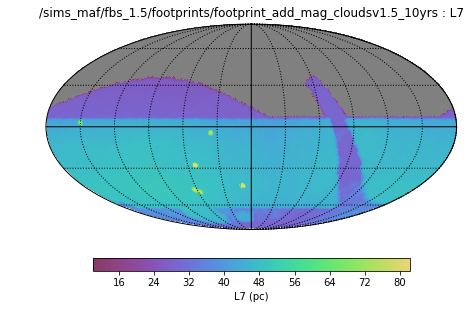

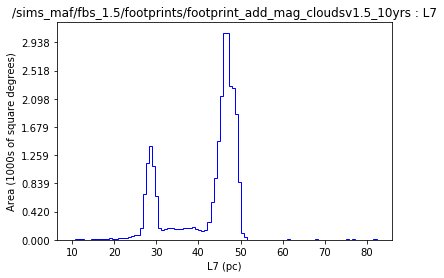

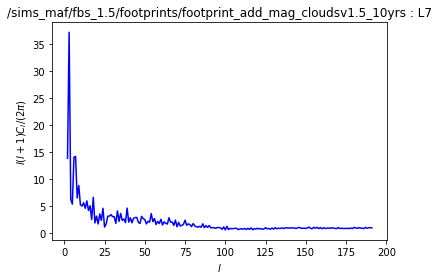

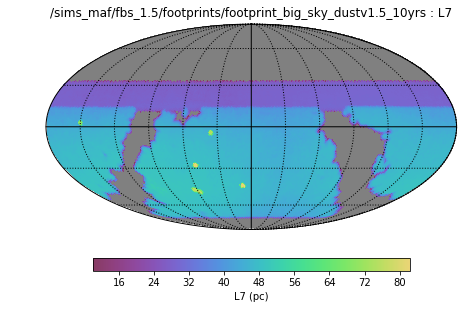

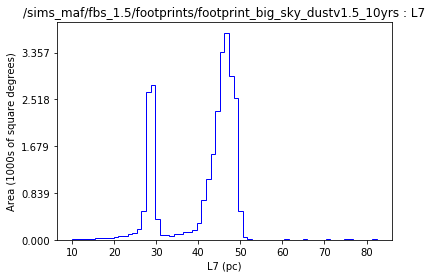

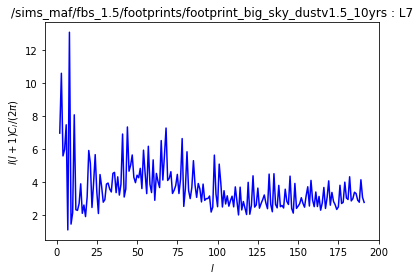

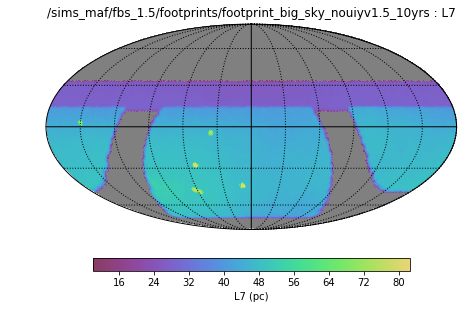

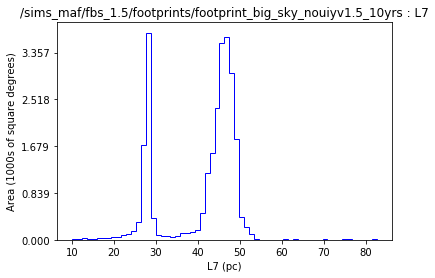

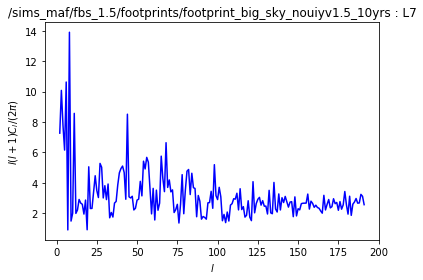

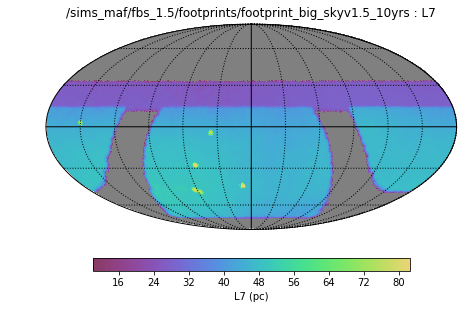

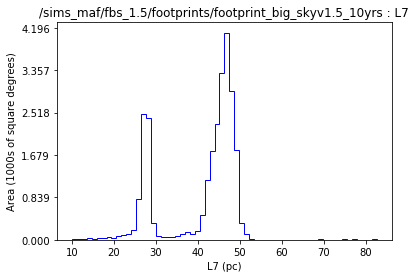

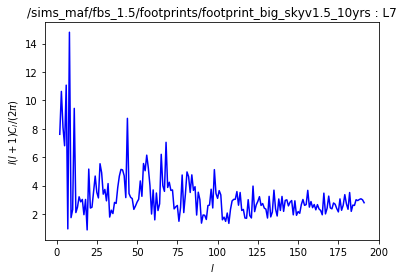

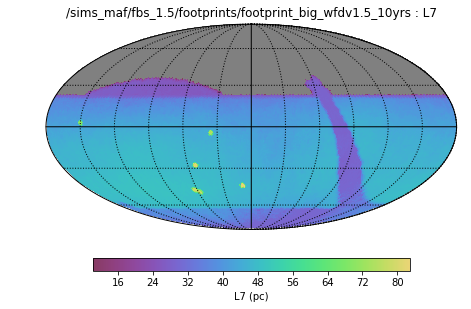

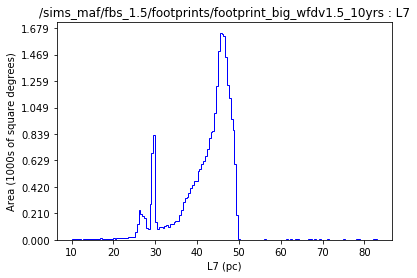

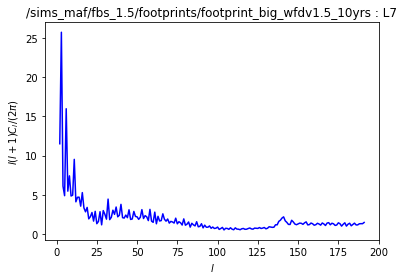

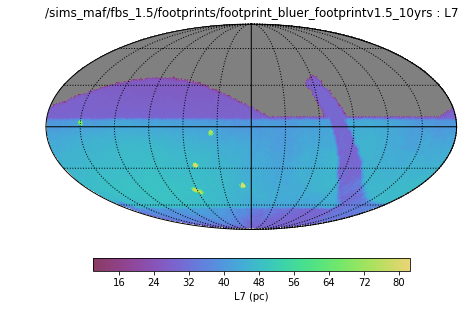

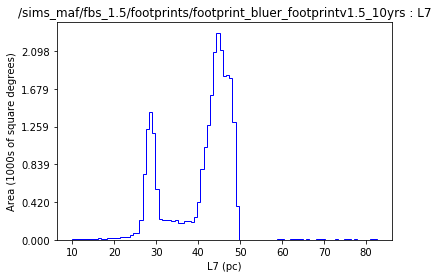

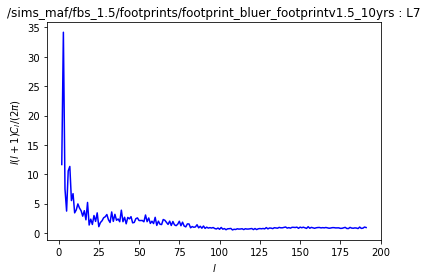

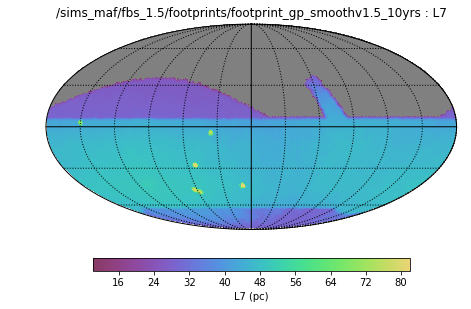

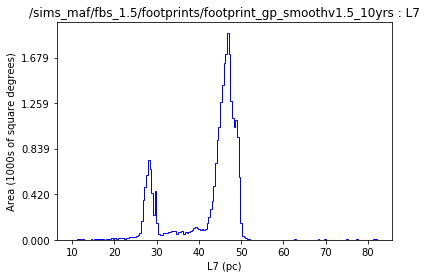

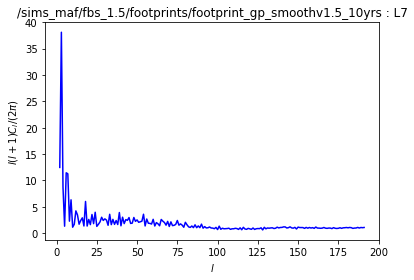

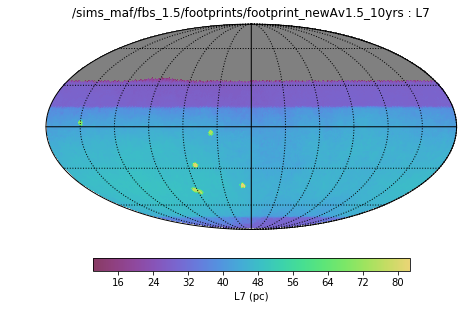

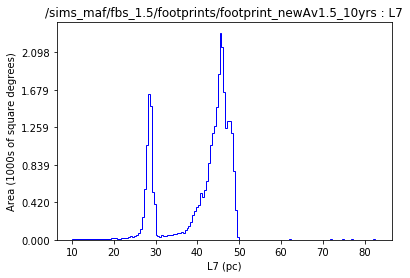

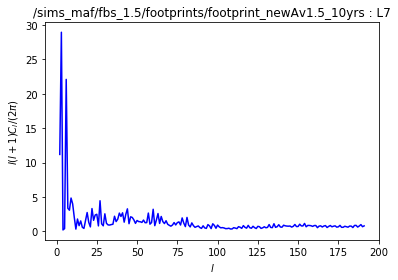

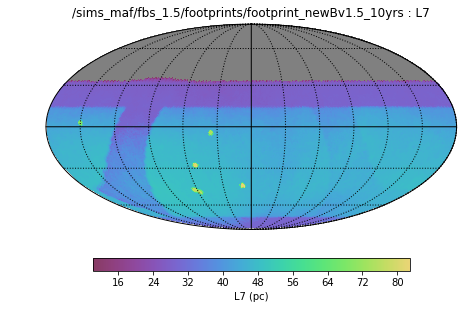

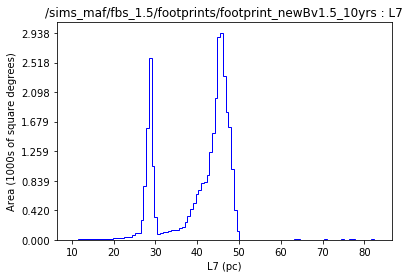

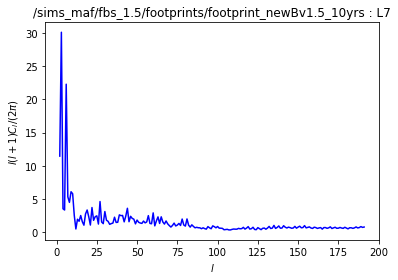

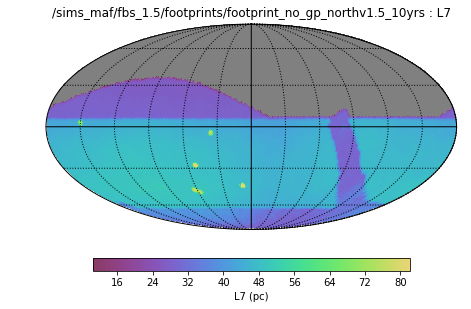

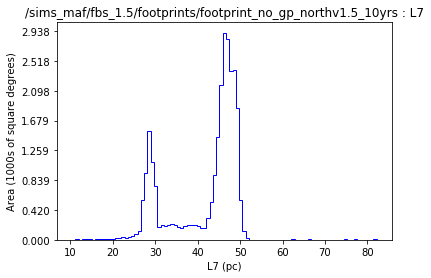

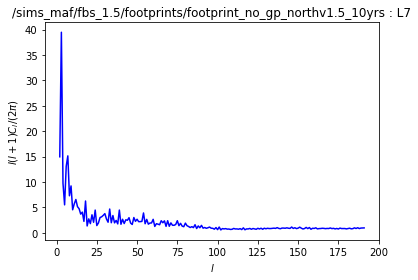

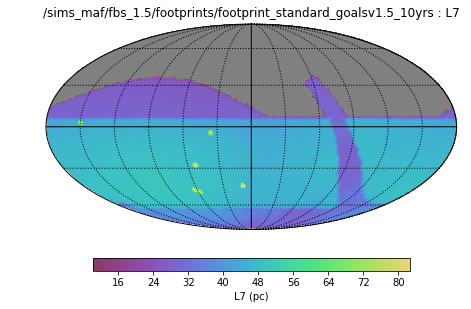

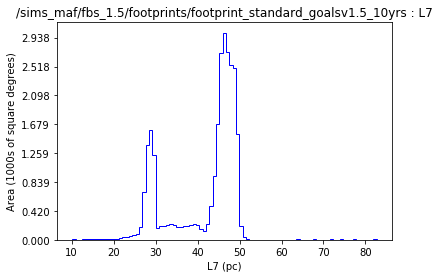

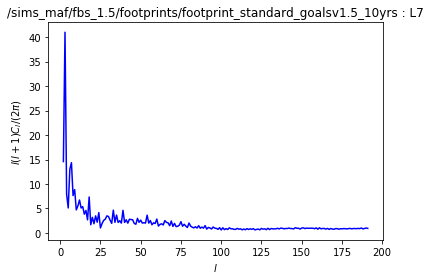

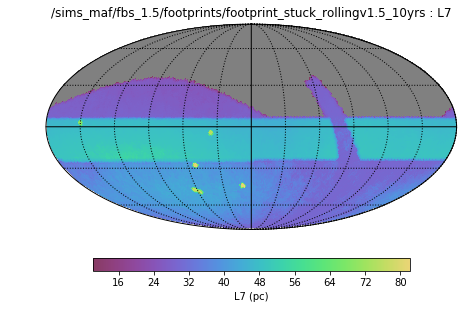

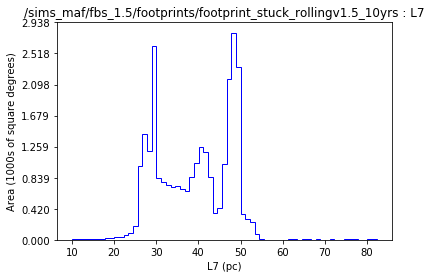

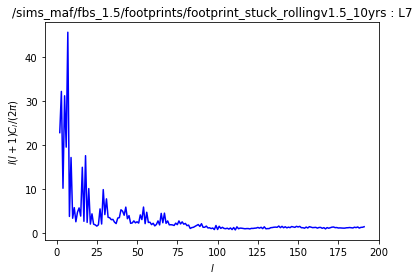

In [5]:
files = glob.glob('/sims_maf/fbs_1.5/footprints/*db')
files.sort()
results = []
for dbFile in files:
    
    runName = dbFile.replace('.db', '')
    conn = db.OpsimDatabase(dbFile)
    
    outDir = runName + '_bdvol'
    outDir=outDir.replace('/sims_maf/fbs_1.5/baseline/',"BDresults/")

    resultsDb = db.ResultsDb(outDir=outDir)
    
    nside = 64
    bundleList = []
    #sql = 'filter="z" or filter="y"'
    sql = ''
    # Let's plug in the magnitudes for one type
    metric = BDParallaxMetric(mags={'i': 20.09, 'z': 18.18, 'y': 17.13}, metricName='L7')
    slicer = slicers.HealpixSlicer(nside=nside)
    summaryStats = [VolumeSumMetric(nside=nside)]
    plotDict = {}
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                                 summaryMetrics=summaryStats,
                                                 runName=runName))
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    bg.plotAll(closefigs=False)

    results.append(bg)

In [6]:
# Let's see how the total volume changes as we change the footprint
for name, result in zip(files, results):
    key = list(result.bundleDict.keys())[0]
    result.bundleDict[key]
    print(name, result.bundleDict[key].summaryValues)

/sims_maf/fbs_1.5/footprints/footprint_add_mag_cloudsv1.5_10yrs.db {'VolumeSum': 226472.16016769054}
/sims_maf/fbs_1.5/footprints/footprint_big_sky_dustv1.5_10yrs.db {'VolumeSum': 214273.02456614905}
/sims_maf/fbs_1.5/footprints/footprint_big_sky_nouiyv1.5_10yrs.db {'VolumeSum': 206229.4306374527}
/sims_maf/fbs_1.5/footprints/footprint_big_skyv1.5_10yrs.db {'VolumeSum': 204769.19435360428}
/sims_maf/fbs_1.5/footprints/footprint_big_wfdv1.5_10yrs.db {'VolumeSum': 239418.2925034677}
/sims_maf/fbs_1.5/footprints/footprint_bluer_footprintv1.5_10yrs.db {'VolumeSum': 203441.29214042914}
/sims_maf/fbs_1.5/footprints/footprint_gp_smoothv1.5_10yrs.db {'VolumeSum': 232415.71300250525}
/sims_maf/fbs_1.5/footprints/footprint_newAv1.5_10yrs.db {'VolumeSum': 247210.07134844578}
/sims_maf/fbs_1.5/footprints/footprint_newBv1.5_10yrs.db {'VolumeSum': 238406.8942668382}
/sims_maf/fbs_1.5/footprints/footprint_no_gp_northv1.5_10yrs.db {'VolumeSum': 223822.610289666}
/sims_maf/fbs_1.5/footprints/footprint_